<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод:</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод:</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Linear-Regression" data-toc-modified-id="Linear-Regression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Linear Regression</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#LGBM" data-toc-modified-id="LGBM-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>LGBM</a></span></li><li><span><a href="#XGBoost" data-toc-modified-id="XGBoost-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>XGBoost</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод:</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Прочитаем файл и импортируем библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV


from sklearn.linear_model import LinearRegression

from catboost import CatBoostRegressor
import catboost as cat

from lightgbm import LGBMRegressor
import lightgbm as lgb

import xgboost as xgb
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/datasets/taxi.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
datetime      26496 non-null object
num_orders    26496 non-null int64
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Заметим тип данных у солбца со временем на *datetime64*

In [4]:
df['datetime'] = pd.to_datetime(df['datetime'],format = '%Y-%m-%d %H:%M:%S')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
datetime      26496 non-null datetime64[ns]
num_orders    26496 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


Установим столбец времени в качестве индекса, проверим данные на монотонность и выполним ресемплирование по часу

In [5]:
df.set_index('datetime', inplace = True)

In [6]:
df.sort_index(inplace = True)

In [7]:
df.index.is_monotonic

True

In [8]:
df = df.resample('1H').sum()

### Вывод:

Провели обработку данных для временного ряда:

В начале перевели в тип Datetime из object и сделали индексом для будущего удобства и избежания путаницы.

Также проверили данные на монотонность и все оказалось хорошо , можно работать дальше

После этого провели ресемплинг с диапозоном в 1 час ,где данные агрегировали с помощью суммы

## Анализ

Проанализируем тренды и сезонность наших данных

In [9]:
decomposed = seasonal_decompose(df)

недельный тренд с 5 по 11 марта

In [10]:
decomposedWeek = seasonal_decompose(df['2018-03-04':'2018-03-12'])
decomposedFewDays = seasonal_decompose(df['2018-03-04':'2018-03-06'])

Месячный тренд за апрель и август - беру их как представителей разных сезонов - весны и лета

In [11]:
decomposedMonth_apr = seasonal_decompose(df['2018-04-01':'2018-05-01'])
decomposedMonth_aug = seasonal_decompose(df['2018-07-31':'2018-08-31'])

Перейдём непосредственно к графикам

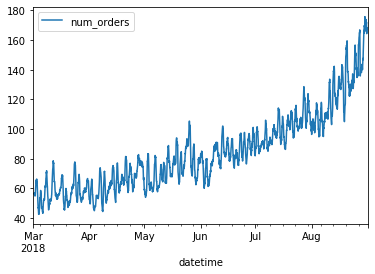

In [12]:
decomposed.trend.plot();

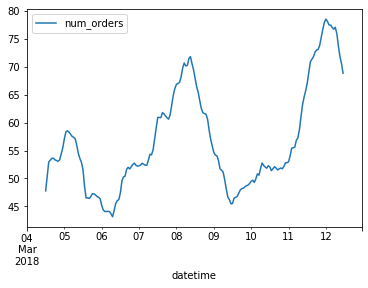

In [13]:
decomposedWeek.trend.plot();

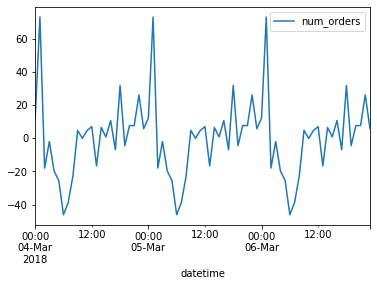

In [14]:
decomposedFewDays.seasonal.plot();

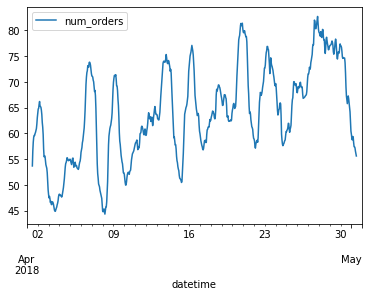

In [15]:
decomposedMonth_apr.trend.plot();

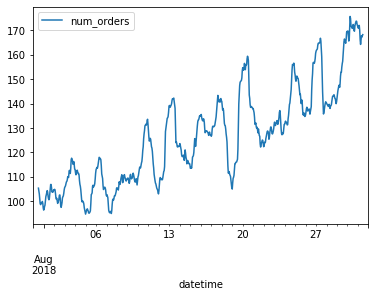

In [16]:
decomposedMonth_aug.trend.plot();

### Вывод:

1) По всем данным: идёт стабильное увеличение заказов к августу, в целом понятно - лето сезон отпусков

(хотя немного странно что пик уже на границе сентября мб связанно с 1 сентября) 

2) По неделям: 3 выброса в понедельник в середине недели и в выходные 
       
       Понедельник день тияжелый можно позволить себе такси
       
       в среду-четверг можно устать от метро и вызвать машину
       
       ну а в выходные надо же как-то до дома из бара добраться)
       
3) по нескольким дням: присутствуют выбросы в 00:00, скорее всего это время ставится если заказ не записал точное время, не думаю что стоит их удалять ибо будет большая потеря. В остальном тоже всё ясно больше всего утром и вечером - на работу и с работы


4) по месяцу апрелю: резкие всплески на границах недели по понедельникам и в выходные


5) по месяцу августу: в августе в целом почти в 2 раза больше заказов чем в апреле, с плавным увеличением к концу месяца и всплесками в понедельник и в выходные

Напишем функцию для подготовки признаков для будущего обучения модели , где выделим календарные признакми:
Год, Месяц, день, день недели и час

а так же - отстающие значения и скользящее среднее , со смещением ,чтобы не было подсматривания данных

In [17]:
def make_features(df, max_lag, rolling_sum_size):
    #calendar features
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
    df['rolling_sum'] = df['num_orders'].shift().rolling(rolling_sum_size).mean()

In [18]:
make_features(df, 24 , 4)

## Обучение

Разделим данные

In [19]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

In [20]:
train_features = train.drop('num_orders', axis = 1)
train_target = train['num_orders']
test_features = test.drop('num_orders', axis = 1)
test_target = test['num_orders']

### Linear Regression

In [21]:
modelLR = LinearRegression()
modelLR.fit(train_features, train_target)
predictionLR = modelLR.predict(test_features)
mean_squared_error(test_target,predictionLR)**0.5

45.810948889069465

### CatBoost

In [22]:
train_dataset = cat.Pool(train_features, train_target)
test_dataset = cat.Pool(test_features, test_target)

In [23]:
modelCat = CatBoostRegressor( random_state = 42)

In [24]:
param_search = {'depth' : [3, 6, 10],
                'learning_rate' : [0.03, 0.1],
                'iterations' : [1000, 2000],
                'verbose' : [False]
               }
tscv = TimeSeriesSplit(n_splits=5)
gsearchCat = GridSearchCV(estimator=modelCat, cv=tscv, param_grid=param_search)
gsearchCat.fit(train_features, train_target)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score='raise-deprecating',
             estimator=<catboost.core.CatBoostRegressor object at 0x7fb07cadfb90>,
             iid='warn', n_jobs=None,
             param_grid={'depth': [3, 6, 10], 'iterations': [1000, 2000],
                         'learning_rate': [0.03, 0.1], 'verbose': [False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [26]:
gsearchCat.best_params_

{'depth': 6, 'iterations': 1000, 'learning_rate': 0.03, 'verbose': False}

### LGBM

In [27]:
modelLight = LGBMRegressor(random_state = 42)
param_search = {'depth' : [-1,3, 6, 10],
                'learning_rate' : [0.03, 0.1],
                'n_estimators' : [100,200,1000]
               }
tscv = TimeSeriesSplit(n_splits=5)
gsearchLight = GridSearchCV(estimator=modelLight, cv=tscv, param_grid=param_search)
gsearchLight.fit(train_features, train_target)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score='raise-deprecating',
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=42,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='warn', n_jobs=None,
             param_grid={'depth': [-1, 3, 6, 10], 'learning_rate': [0.03, 0.1],
                         'n_esti

In [29]:
gsearchLight.best_params_

{'depth': -1, 'learning_rate': 0.03, 'n_estimators': 200}

### XGBoost

In [30]:
modelXGB = XGBRegressor(random_state = 42)
param_search = {'max_depth' : [3, 6, 10],
                'learning_rate' : [0.03, 0.1],
                'n_estimators' : [1000, 2000]
               }
tscv = TimeSeriesSplit(n_splits=5)
gsearchXGB = GridSearchCV(estimator=modelXGB, cv=tscv, param_grid=param_search)
gsearchXGB.fit(train_features, train_target)

[00:11:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:11:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:11:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:11:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:11:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:12:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:12:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:12:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=42,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'learning_rate': [0.03, 0.1], 'max_d

In [32]:
gsearchXGB.best_params_

{'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 1000}

## Тестирование

In [33]:
import catboost as cat

In [34]:
train_dataset = cat.Pool(train_features, train_target)
test_dataset = cat.Pool(test_features, test_target)

In [35]:
modelCat = CatBoostRegressor(depth = 6, iterations = 2000, learning_rate = 0.03, loss_function = 'RMSE')
modelCat.fit(train_dataset, eval_set = test_dataset, plot = True, verbose = False);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [36]:
mean_squared_error(test_target, modelCat.predict(test_features))**0.5
prediction = modelCat.predict(test_features)

In [44]:
print(mean_squared_error(test_target, modelCat.predict(test_features))**0.5)

39.80365964318777


In [37]:
lgbm = LGBMRegressor(depth = -1,n_estimators = 200, learning_rate = 0.03, random_state = 42)
lgbm.fit(train_features,train_target, eval_set = (test_features,test_target), eval_metric = 'RMSE', verbose = 10);

[10]	valid_0's rmse: 72.5262	valid_0's l2: 5260.05
[20]	valid_0's rmse: 64.2718	valid_0's l2: 4130.86
[30]	valid_0's rmse: 58.2176	valid_0's l2: 3389.29
[40]	valid_0's rmse: 53.9772	valid_0's l2: 2913.54
[50]	valid_0's rmse: 50.7778	valid_0's l2: 2578.38
[60]	valid_0's rmse: 48.5291	valid_0's l2: 2355.08
[70]	valid_0's rmse: 46.8864	valid_0's l2: 2198.34
[80]	valid_0's rmse: 45.5346	valid_0's l2: 2073.4
[90]	valid_0's rmse: 44.5065	valid_0's l2: 1980.83
[100]	valid_0's rmse: 43.9461	valid_0's l2: 1931.26
[110]	valid_0's rmse: 43.4538	valid_0's l2: 1888.23
[120]	valid_0's rmse: 42.8911	valid_0's l2: 1839.64
[130]	valid_0's rmse: 42.4096	valid_0's l2: 1798.58
[140]	valid_0's rmse: 42.0393	valid_0's l2: 1767.3
[150]	valid_0's rmse: 41.7416	valid_0's l2: 1742.36
[160]	valid_0's rmse: 41.4915	valid_0's l2: 1721.54
[170]	valid_0's rmse: 41.3329	valid_0's l2: 1708.41
[180]	valid_0's rmse: 41.2221	valid_0's l2: 1699.27
[190]	valid_0's rmse: 41.1826	valid_0's l2: 1696.01
[200]	valid_0's rmse: 4

In [38]:
mean_squared_error(test_target, lgbm.predict(test_features))**0.5

41.00988569436097

In [39]:
modelXGB = XGBRegressor(max_depth = 3, n_estimators = 1000, learning_rate = 0.03,random_state = 42)
modelXGB.fit(train_features, train_target, eval_set = [(train_features, train_target),(test_features, test_target)], eval_metric = 'rmse', verbose = 10);

[00:21:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:84.6578	validation_1-rmse:147.948
[10]	validation_0-rmse:65.1012	validation_1-rmse:122.61
[20]	validation_0-rmse:51.2361	validation_1-rmse:103.194
[30]	validation_0-rmse:41.5792	validation_1-rmse:89.0527
[40]	validation_0-rmse:35.0252	validation_1-rmse:78.6465
[50]	validation_0-rmse:30.6542	validation_1-rmse:70.5427
[60]	validation_0-rmse:27.7831	validation_1-rmse:64.8437
[70]	validation_0-rmse:25.9584	validation_1-rmse:59.7615
[80]	validation_0-rmse:24.793	validation_1-rmse:56.4338
[90]	validation_0-rmse:23.9303	validation_1-rmse:53.4476
[100]	validation_0-rmse:23.3659	validation_1-rmse:51.5511
[110]	validation_0-rmse:22.9247	validation_1-rmse:49.7697
[120]	validation_0-rmse:22.5691	validation_1-rmse:48.5186
[130]	validation_0-rmse:22.2691	validation_1-rmse:47.5369
[140]	validation_0-rmse:22.0185	validation_1-rmse:46.7824
[150]	validation

In [40]:
mean_squared_error(test_target, modelXGB.predict(test_features))**0.5

42.228906348015535

In [41]:
frame = {'Target':test_target, 'Prediction':prediction}

In [42]:
result = pd.DataFrame(frame)

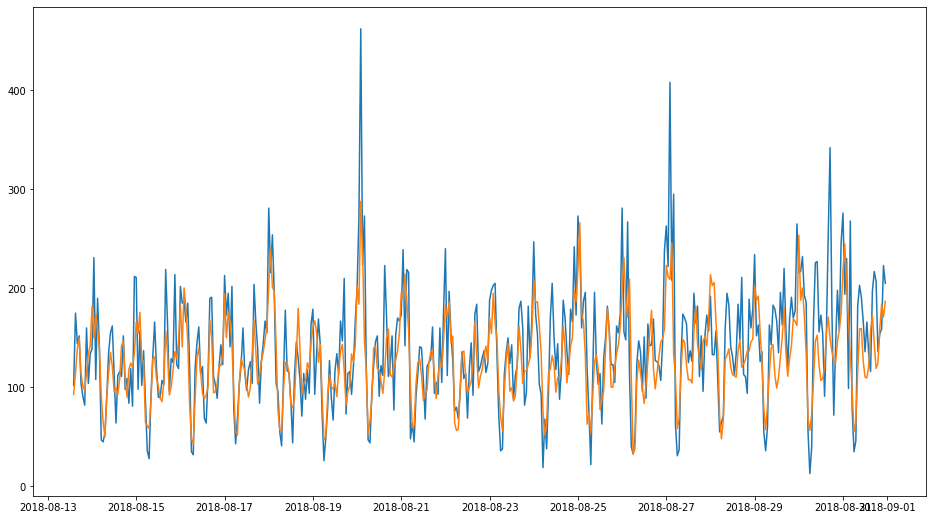

In [43]:
plt.figure(figsize=(16,9))
plt.plot(result);

## Вывод:

Лучше всех себя показала модель CatBoost, хотя все модели подходят под условие

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48